##   Imported libraries

In [2]:
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from scipy import sparse
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_validate, train_test_split
from xgboost import XGBClassifier
import missingno as msno
from Optimization.PreparedData import X_train, X_valid, y_train, y_valid
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split

##  EDA

In [3]:
train_df = pd.read_csv('datasets/train.csv', index_col='id')
test_df = pd.read_csv('datasets/test.csv', index_col='id')
submission_df = pd.read_csv('datasets/sample_submission.csv', index_col='id')

In [7]:
train_df.shape, test_df.shape

((595212, 58), (892816, 57))

In [8]:
train_df.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [9]:
submission_df.head()

,target
id,
0,0.0364
1,0.0364
2,0.0364
3,0.0364
4,0.0364


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17_bin 

In [11]:
train_copy_df = train_df.copy().replace(-1, np.nan)

<Axes: >

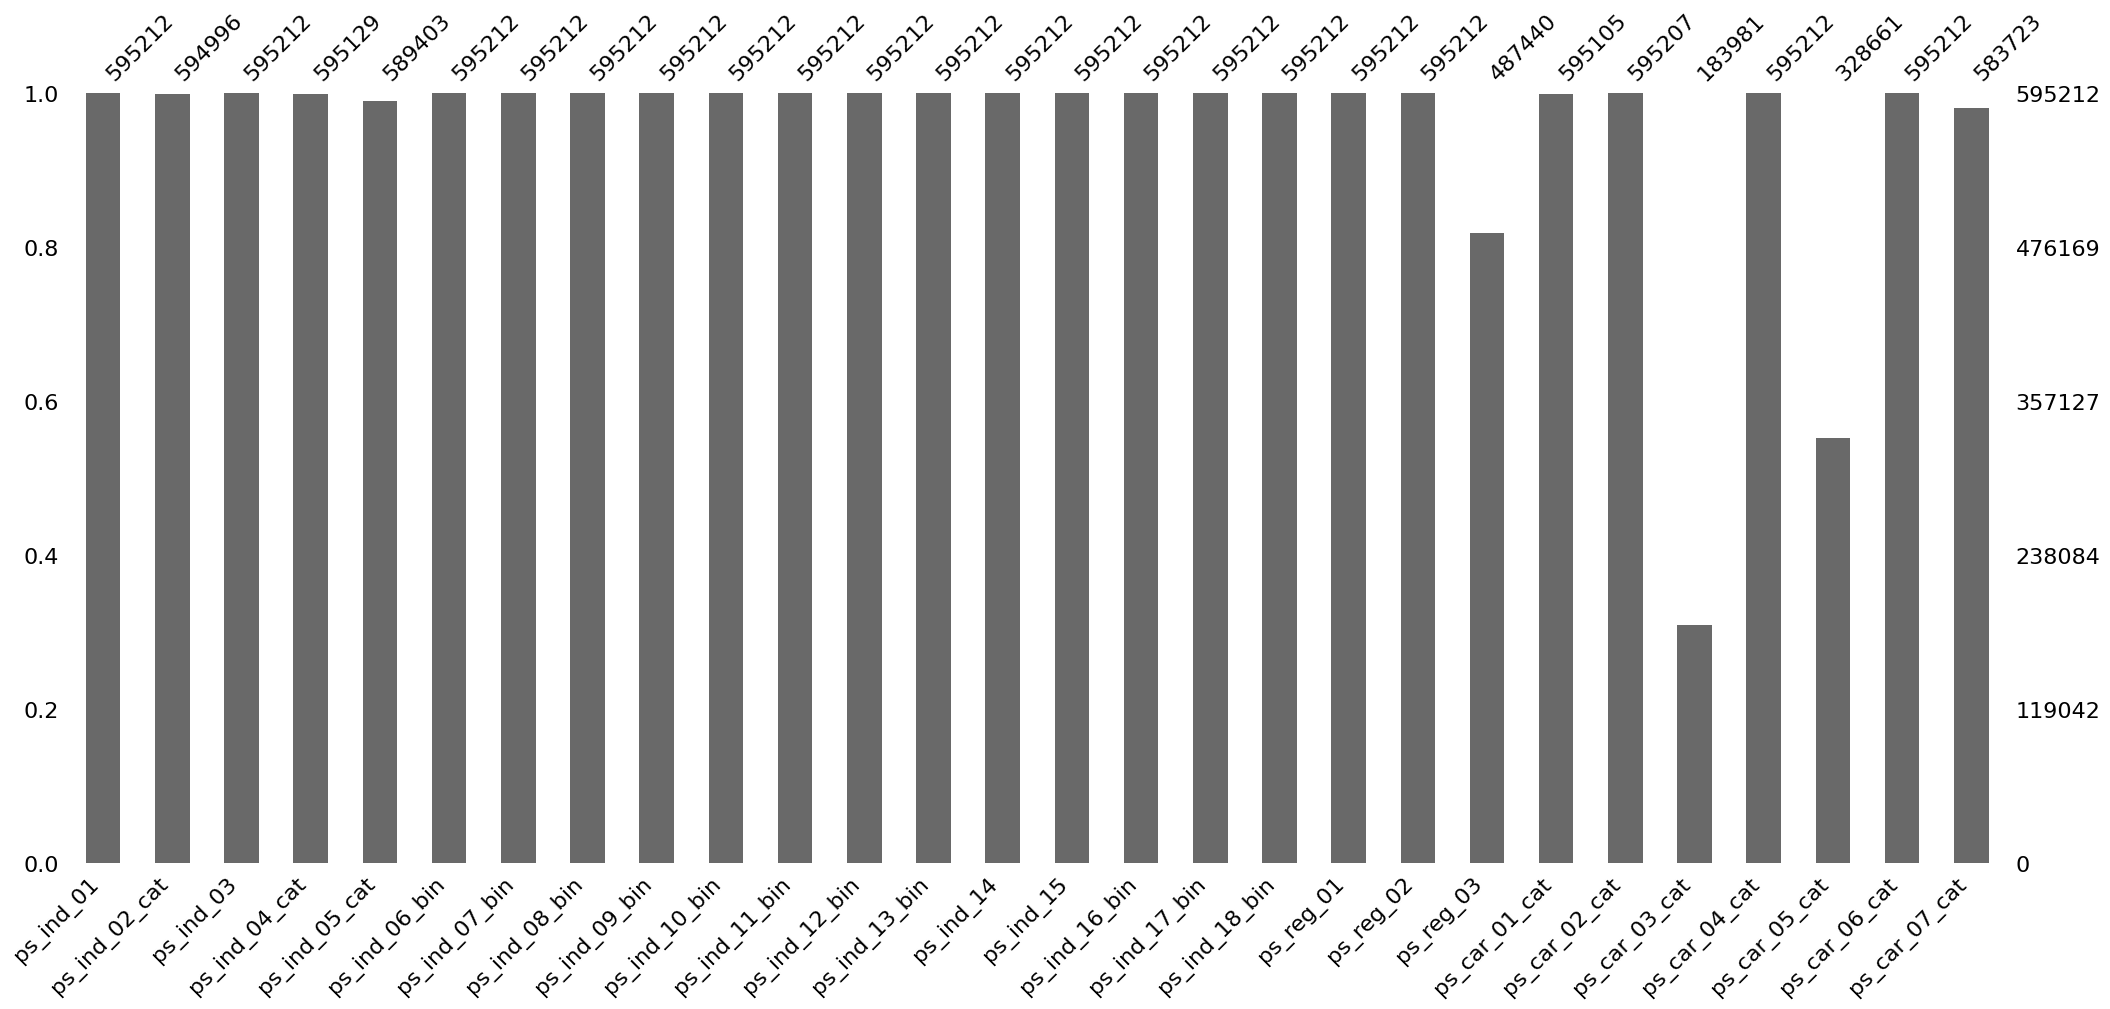

In [12]:
msno.bar(df=train_copy_df.iloc[:, 1:29])

<Axes: >

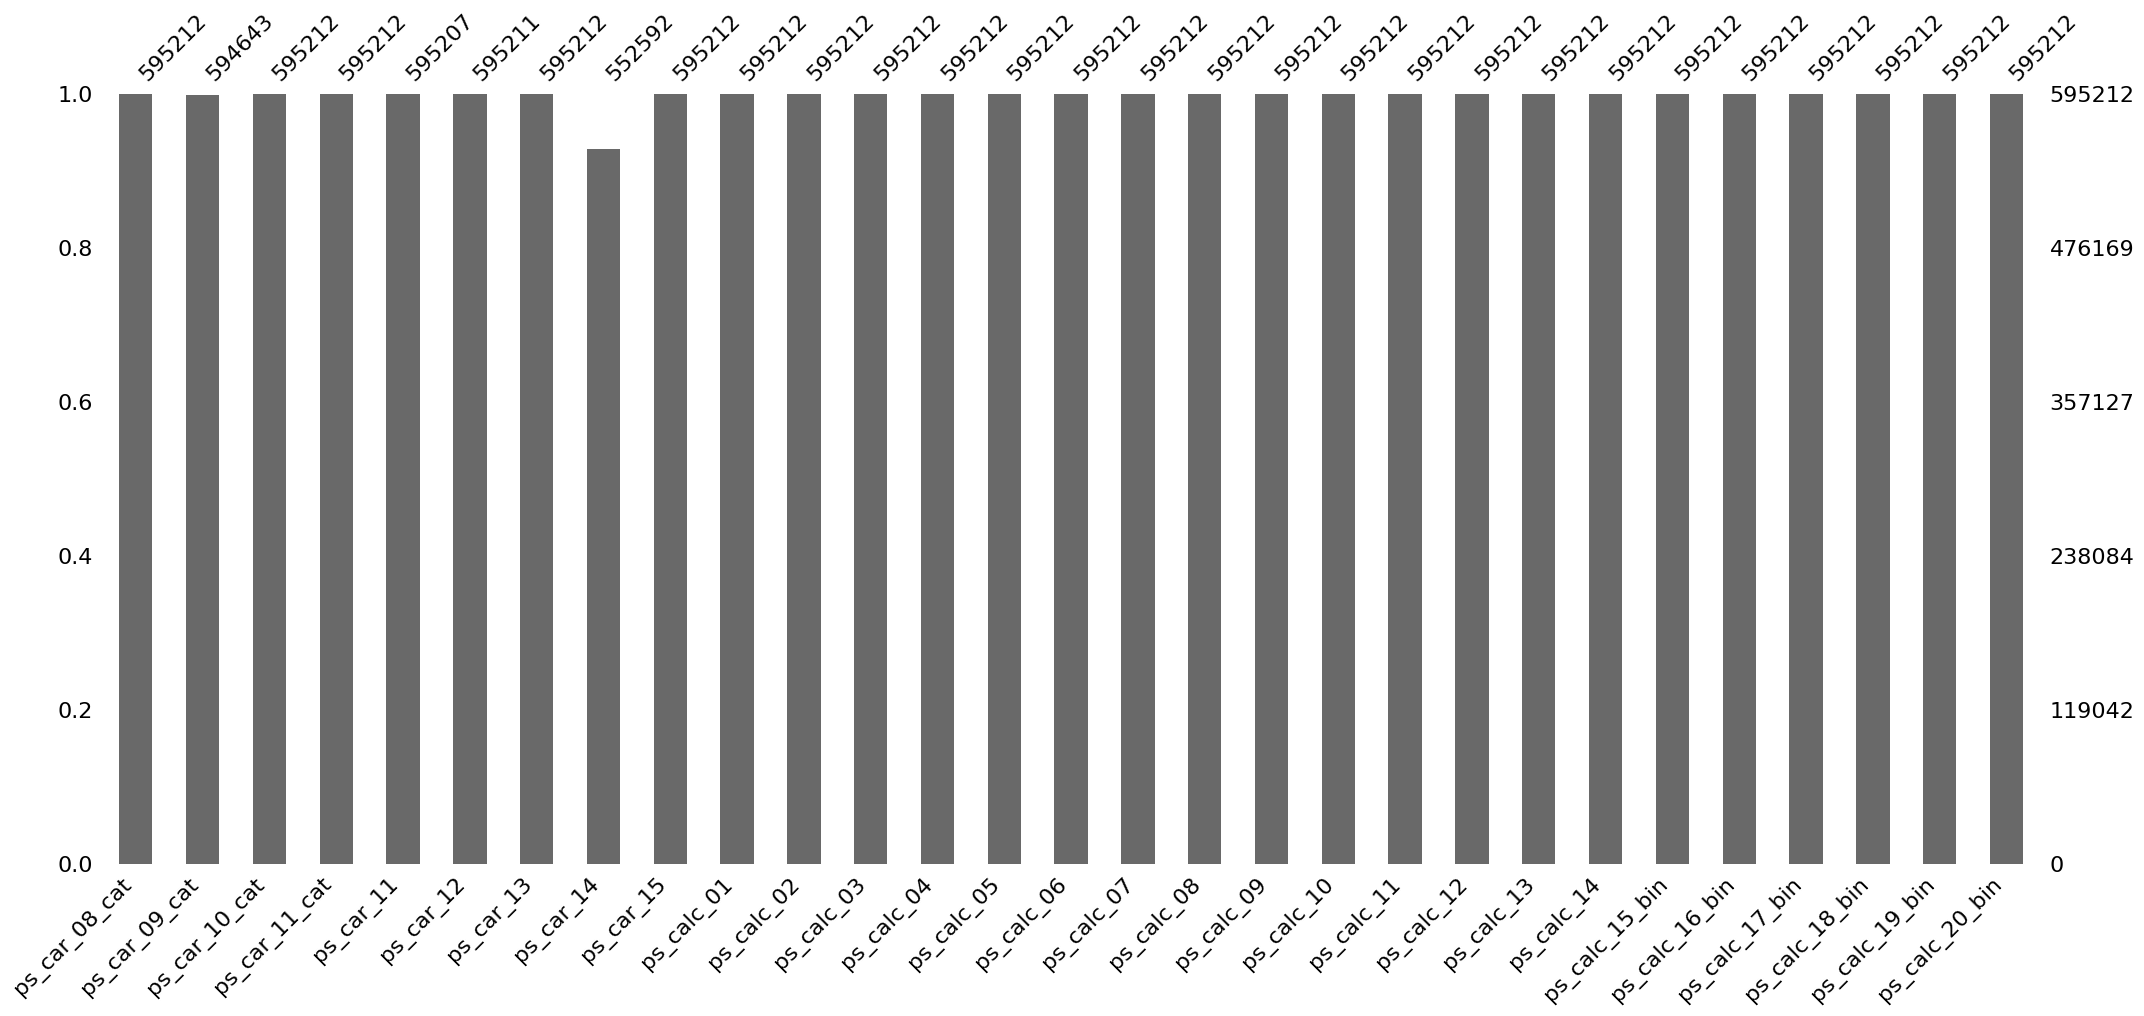

In [13]:
msno.bar(df=train_copy_df.iloc[:, 29:])

In [14]:
def resumetable(df):
    print(f'shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['dtype'])
    summary['missing'] = (df == -1).sum().values
    summary['unique'] = df.nunique().values
    summary['type'] = None
    for col in df.columns:
        if 'bin' in col or col == 'target':
            summary.loc[col, 'type'] = 'binary'
        elif 'cat' in col:
            summary.loc[col, 'type'] = 'nominal'
        elif df[col].dtype == float:
            summary.loc[col, 'type'] = 'continuous'
        elif df[col].dtype == int:
            summary.loc[col, 'type'] = 'ordinal'
    return summary

In [15]:
summary_df = resumetable(train_df)
summary_df

shape: (595212, 58)


,dtype,missing,unique,type
target,int64,0,2,binary
ps_ind_01,int64,0,8,ordinal
ps_ind_02_cat,int64,216,5,nominal
ps_ind_03,int64,0,12,ordinal
ps_ind_04_cat,int64,83,3,nominal
ps_ind_05_cat,int64,5809,8,nominal
ps_ind_06_bin,int64,0,2,binary
ps_ind_07_bin,int64,0,2,binary
ps_ind_08_bin,int64,0,2,binary
ps_ind_09_bin,int64,0,2,binary


In [16]:
def write_percent(ax, total_size):
    for patch in ax.patches:
        height = patch.get_height()
        width = patch.get_width()
        left_coord = patch.get_x()
        percent = height/total_size*100
        
        ax.text(left_coord + width/2.0,
               height + total_size*0.001,
               '{:1.1f}%'.format(percent),
               ha='center')

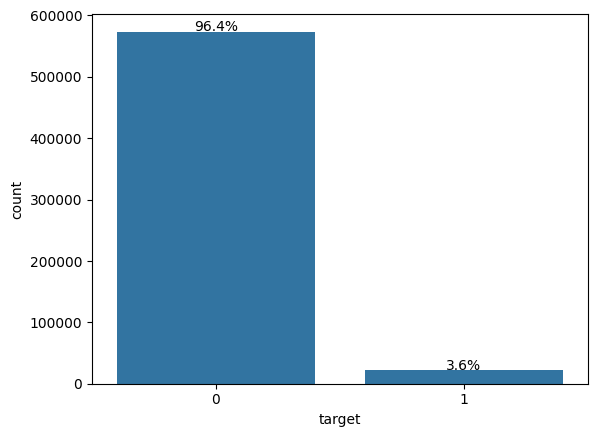

In [17]:
ax = sns.countplot(x='target', data=train_df)
write_percent(ax, len(train_df))

In [18]:
def plot_target_ratio_by_features(df, featuers, num_rows, num_cols):
    plt.figure(figsize=(12, 18))
    grid = gridspec.GridSpec(num_rows, num_cols)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    for idx, feature in enumerate(featuers):
        ax = plt.subplot(grid[idx])
        sns.barplot(x=feature, y='target', data=df, ax=ax)

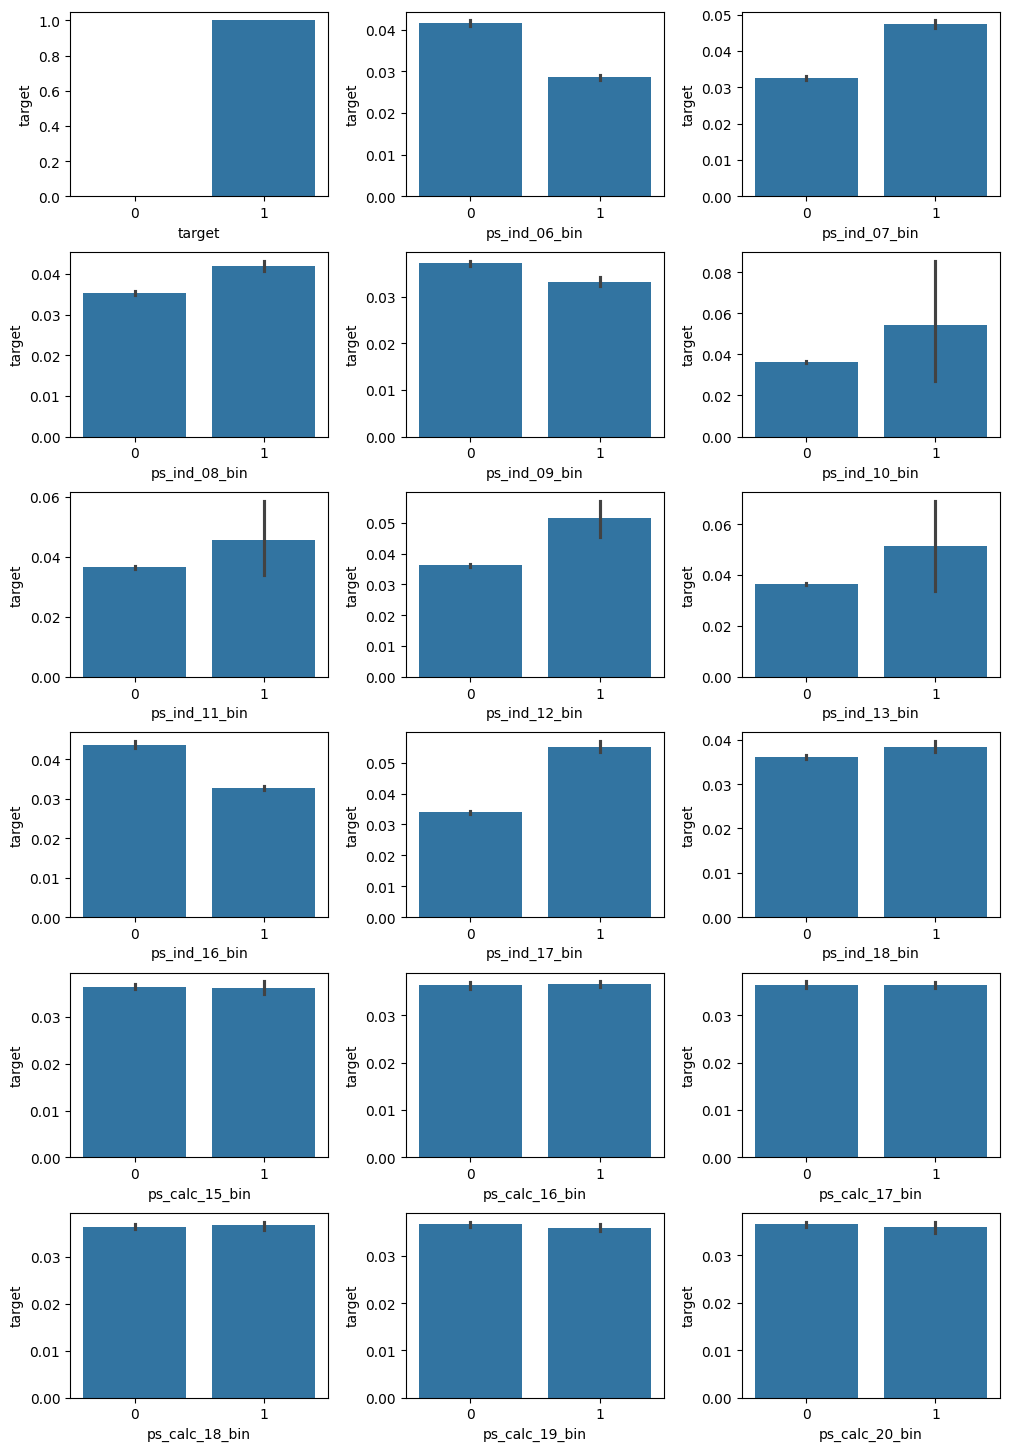

In [19]:
bin_features = summary_df[summary_df['type'] == 'binary'].index
plot_target_ratio_by_features(train_df, bin_features, 6, 3)

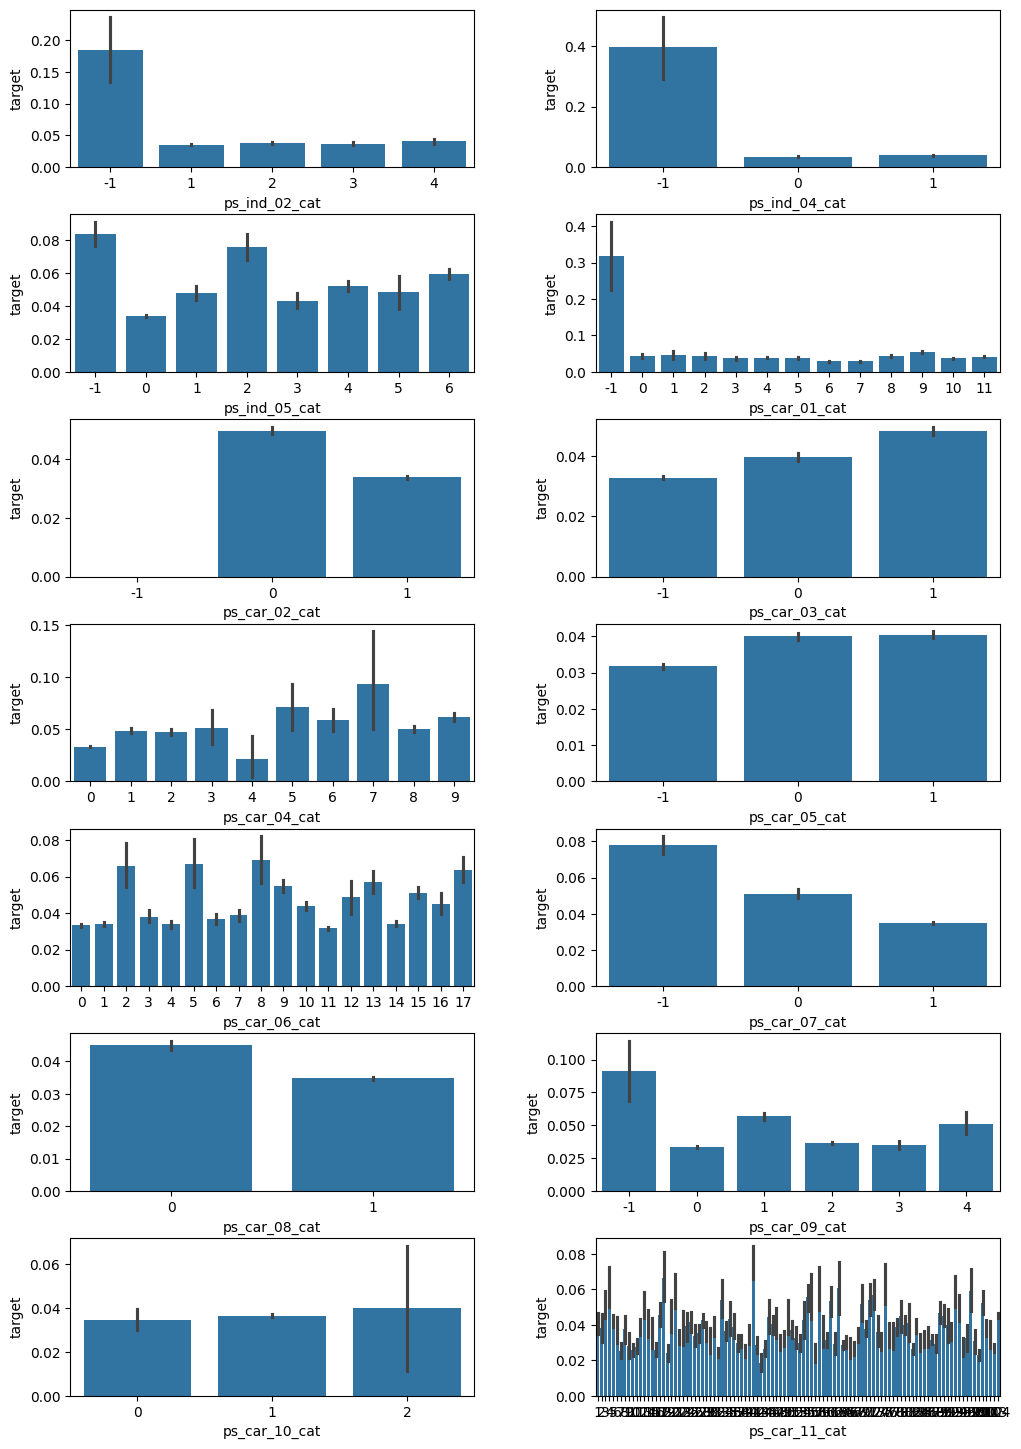

In [20]:
nom_features = summary_df[summary_df['type'] == 'nominal'].index
plot_target_ratio_by_features(train_df, nom_features, 7, 2)

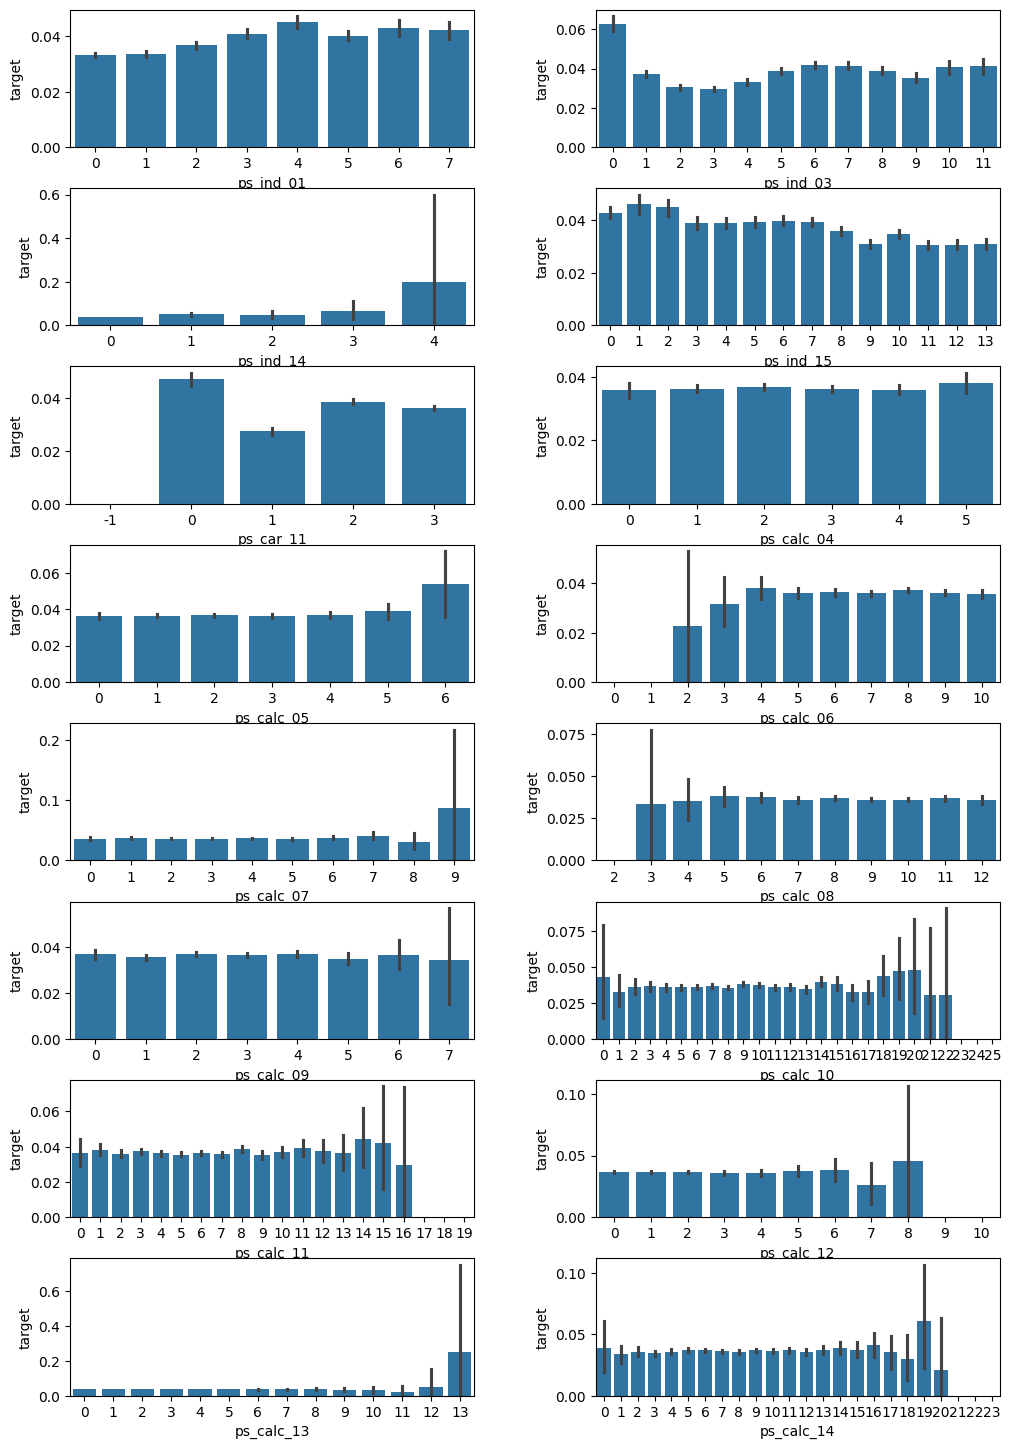

In [21]:
ord_features = summary_df[summary_df['type'] == 'ordinal'].index
plot_target_ratio_by_features(train_df, ord_features, 8, 2)

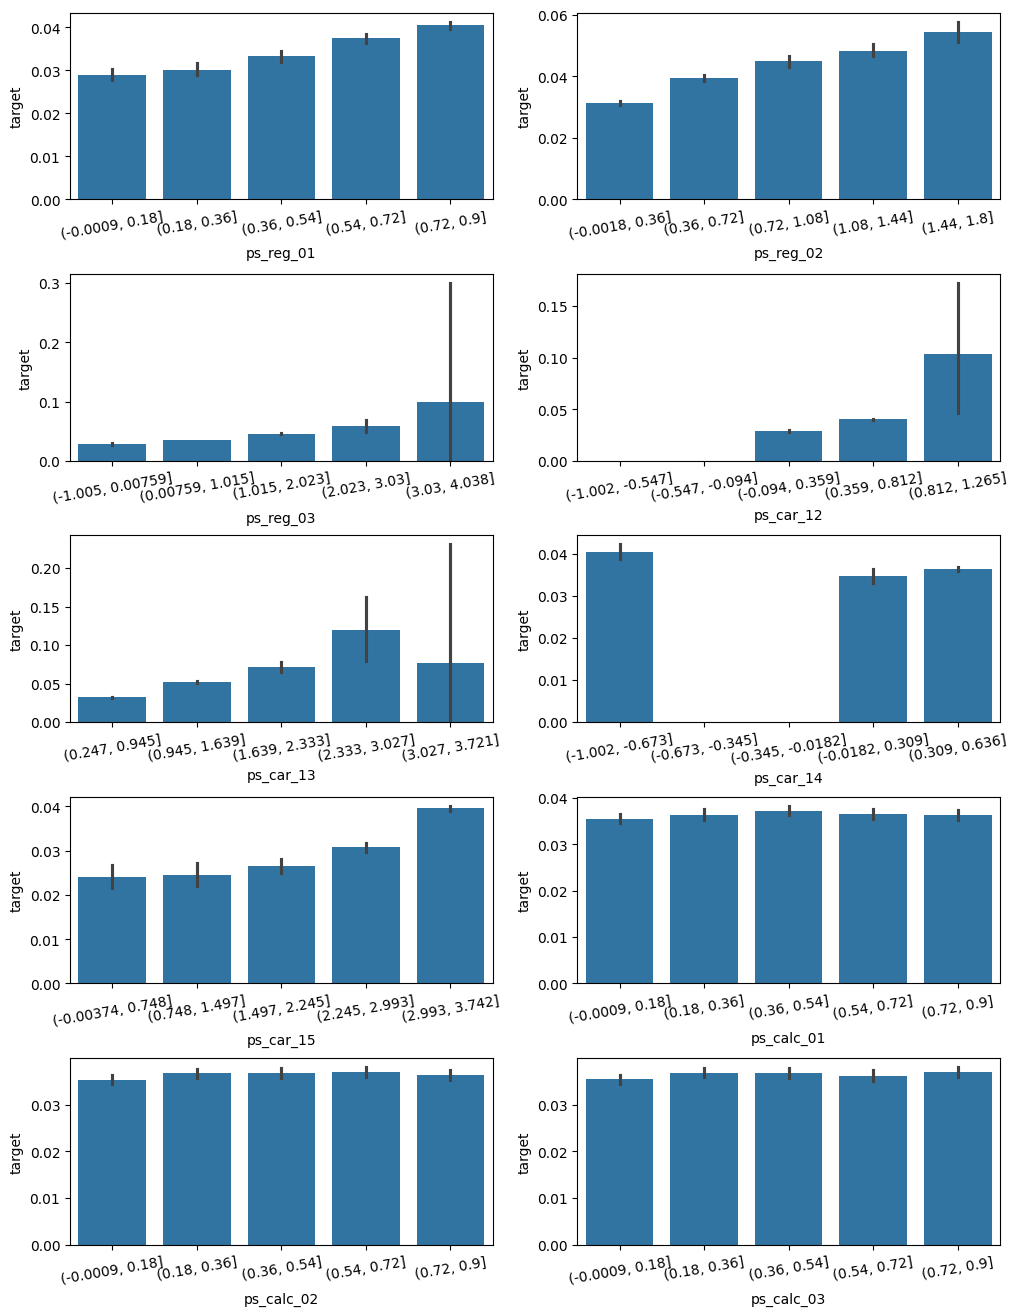

In [22]:
cont_features = summary_df[summary_df['type'] == 'continuous'].index

plt.figure(figsize=(12, 16))
grid = gridspec.GridSpec(5, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.4)

for idx, cont_feature in enumerate(cont_features):
    train_df[cont_feature] = pd.cut(train_df[cont_feature], 5)
    
    ax = plt.subplot(grid[idx])
    sns.barplot(x=cont_feature, y='target', data=train_df, ax=ax)
    ax.tick_params(axis='x', labelrotation=10)

<Axes: >

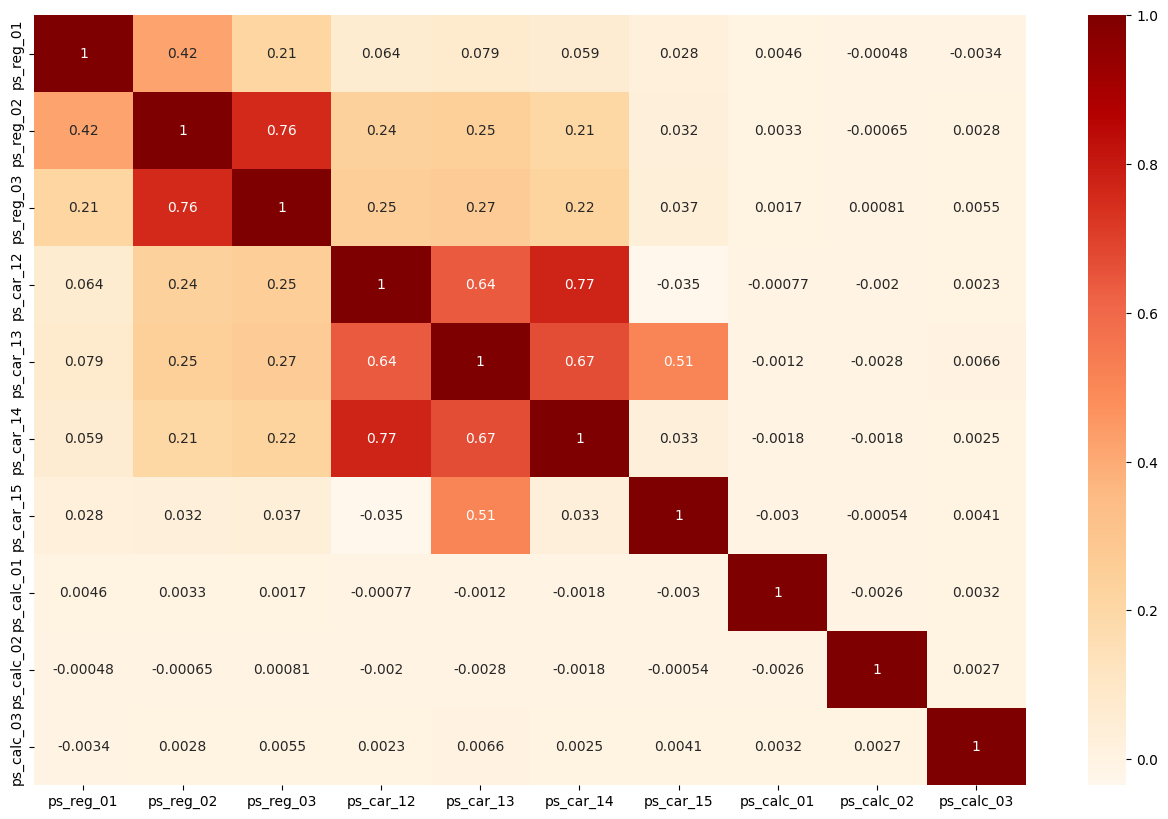

In [23]:
train_copy_df = train_copy_df.dropna()

plt.figure(figsize=(16, 10))
cont_corr = train_copy_df[cont_features].corr()
sns.heatmap(cont_corr, annot=True, cmap='OrRd')

In [24]:
all_df = pd.concat([train_df, test_df], ignore_index=True)
all_df = all_df.drop('target', axis=1)

all_features = all_df.columns
all_features

Index(['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat',
       'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat',
       'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat',
       'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_car_11',
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06',
       'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11',
       'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_calc_15_bin',
       'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin',
       'ps_calc_20_bin'],
      dtype='obj

In [25]:
cat_featuers = [feature for feature in all_features if 'cat' in feature]

onehot_encoder = OneHotEncoder()

encoded_cat_matrix = onehot_encoder.fit_transform(all_df[cat_featuers])

In [26]:
all_df['num_missing'] = (all_df == -1).sum(axis=1)

remaining_features = [feature for feature in all_features if ('cat' not in feature and 'calc' not in feature)]

remaining_features.append('num_missing')

In [27]:
ind_features = [feature for feature in all_features if 'ind' in feature]

is_first_feature = True
for ind_feature in ind_features:
    if is_first_feature:
        all_df['mix_ind'] = all_df[ind_feature].astype(str) + '_'
        is_first_feature = False
    else:
        all_df['mix_ind'] += all_df[ind_feature].astype(str) + '_'

In [28]:
all_df['mix_ind']

0          2_2_5_1_0_0_1_0_0_0_0_0_0_0_11_0_1_0_
1           1_1_7_0_0_0_0_1_0_0_0_0_0_0_3_0_0_1_
2          5_4_9_1_0_0_0_1_0_0_0_0_0_0_12_1_0_0_
3           0_1_2_0_0_1_0_0_0_0_0_0_0_0_8_1_0_0_
4           0_2_0_1_0_1_0_0_0_0_0_0_0_0_9_1_0_0_
                           ...                  
1488023     0_1_6_0_0_0_1_0_0_0_0_0_0_0_2_0_0_1_
1488024    5_3_5_1_0_0_0_1_0_0_0_0_0_0_11_1_0_0_
1488025     0_1_5_0_0_1_0_0_0_0_0_0_0_0_5_0_0_1_
1488026    6_1_5_1_0_0_0_0_1_0_0_0_0_0_13_1_0_0_
1488027    7_1_4_1_0_0_0_0_1_0_0_0_0_0_12_1_0_0_
Name: mix_ind, Length: 1488028, dtype: object

In [29]:
all_df['ps_ind_02_cat'].value_counts().to_dict()

{1: 1079327, 2: 309747, 3: 70172, 4: 28259, -1: 523}

In [30]:
cat_count_features = []
for feature in cat_featuers + ['mix_ind']:
    val_counts_dict = all_df[feature].value_counts().to_dict()
    all_df[f'{feature}_count'] = all_df[feature].apply(lambda x: val_counts_dict[x])
    
    cat_count_features.append(f'{feature}_count')

cat_count_features

['ps_ind_02_cat_count',
 'ps_ind_04_cat_count',
 'ps_ind_05_cat_count',
 'ps_car_01_cat_count',
 'ps_car_02_cat_count',
 'ps_car_03_cat_count',
 'ps_car_04_cat_count',
 'ps_car_05_cat_count',
 'ps_car_06_cat_count',
 'ps_car_07_cat_count',
 'ps_car_08_cat_count',
 'ps_car_09_cat_count',
 'ps_car_10_cat_count',
 'ps_car_11_cat_count',
 'mix_ind_count']

In [31]:
drop_features = ['ps_ind_14', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_14']

all_df_remaining = all_df[remaining_features + cat_count_features].drop(drop_features, axis=1)

bad_cols = all_df_remaining.select_dtypes(include=["object"])

all_df_remaining[bad_cols.columns] = (
    all_df_remaining[bad_cols.columns]
    .apply(pd.to_numeric, errors="coerce")
)

In [32]:
all_df_sprs = sparse.hstack([sparse.csr_matrix(all_df_remaining),
                            encoded_cat_matrix],
                           format='csr')

In [33]:
num_train = len(train_df)

X = all_df_sprs[:num_train]
X_test = all_df_sprs[num_train:]

y = train_df['target'].values

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)